In [2]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division


In [3]:
file_path = '~/Desktop/retailer_data.csv'

df_data = pd.read_csv(file_path)

In [4]:
df_data.head()

,order_number,line_item,order_date,customer_key,store_key,product_key,quantity,currency_code,product_name,brand,...,city,gender,zip_code,birthday,birth_year,order_year,order_month,age_purchase,age_group,years_open
0,366000,1,2016-01-01,265598,10,1304,1,CAD,Contoso Lens Adapter M450 White,Contoso,...,London,Male,N5W 5K6,1971-03-23,1971,2016,1,45,36-45,0.745205
1,1749017,1,2019-10-15,265598,0,1619,1,CAD,Contoso DVD Player M130 Grey,Contoso,...,London,Male,N5W 5K6,1971-03-23,1971,2019,10,48,46-55,9.791781
2,1749017,3,2019-10-15,265598,0,52,1,CAD,WWI 2GB Pulse Smart pen M100 Silver,Wide World Importers,...,London,Male,N5W 5K6,1971-03-23,1971,2019,10,48,46-55,9.791781
3,1749017,2,2019-10-15,265598,0,1764,2,CAD,MGS Age of Empires II: The Age of Kings E126,Tailspin Toys,...,London,Male,N5W 5K6,1971-03-23,1971,2019,10,48,46-55,9.791781
4,891000,2,2017-06-09,265598,9,174,1,CAD,SV 22xDVD M600 Black,Southridge Video,...,London,Male,N5W 5K6,1971-03-23,1971,2017,6,46,46-55,12.273973


In [5]:
df_data['order_date'] = pd.to_datetime(df_data['order_date'])

In [6]:
df_data['order_date'].dtype

dtype('<M8[ns]')

# Customer Segmentation & Lifetime Value

In the previous notebook, we analyzed the major metrics for our electrionic retailer. Now we'll focus on customers, segment them, and then calculate their life time value. 

We will also use these segments as additional features for our dataset that we'll plug into our Machine Learning Model. 

For Customer Segmentation we will cover RFM which stands for:
- Recency
- Frequency
- Monetary Value


Customers will be determined on:

- Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
- Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
- High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

# Recency Clusters

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [7]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df_data['customer_key'].unique())
df_user.columns = ['CustomerID']
df_user

,CustomerID
0,265598
1,302645
2,363584
3,391900
4,211746
...,...
11882,475779
11883,569989
11884,454833
11885,416365


In [8]:
#get the max purchase date for each customer and create a dataframe with it
df_max_purchase = df_data.groupby('customer_key')['order_date'].max().reset_index()
df_max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']
df_max_purchase

,CustomerID,MaxPurchaseDate
0,301,2019-11-11
1,325,2020-01-04
2,554,2019-12-05
3,1042,2018-03-06
4,1314,2017-12-19
...,...,...
11882,2099383,2020-05-30
11883,2099600,2018-08-08
11884,2099758,2020-06-10
11885,2099862,2020-01-01


In [9]:
#Calculate Recency based on the max order date in the dataset
#This means the latest purchase in our data

max_date = df_max_purchase['MaxPurchaseDate'].max()
max_date


Timestamp('2021-02-20 00:00:00')

In [10]:
df_max_purchase['Recency'] = (max_date - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['CustomerID', 'Recency']], on='CustomerID')
df_user.head()

,CustomerID,Recency
0,265598,494
1,302645,347
2,363584,96
3,391900,737
4,211746,791


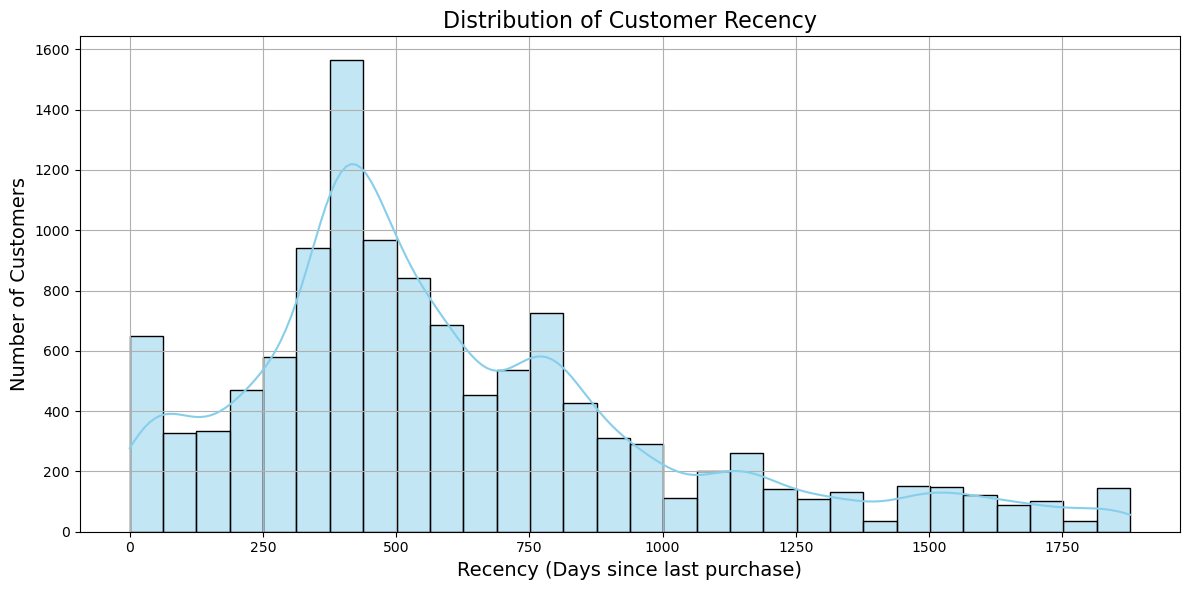

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df_user['Recency'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Customer Recency', fontsize=16)
plt.xlabel('Recency (Days since last purchase)', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)


plt.grid()
plt.tight_layout()
plt.show()

In [12]:
df_user['Recency'].describe()

count    11887.000000
mean       614.142088
std        406.202795
min          0.000000
25%        366.000000
50%        508.000000
75%        795.000000
max       1877.000000
Name: Recency, dtype: float64

We can see that the average recency is 614 days, with a median of 508 days. This is not surprising, given that most sales are related to categories like computers and home appliances, which customers tend to purchase less frequently due to the long lifespan of these products.

**Applying K-means** - We are going to apply K-means clustering to assign a recency score. First we need to figure out how many clusters to plug into the K-means algorithm. To find it out, we will apply Elbow Method.

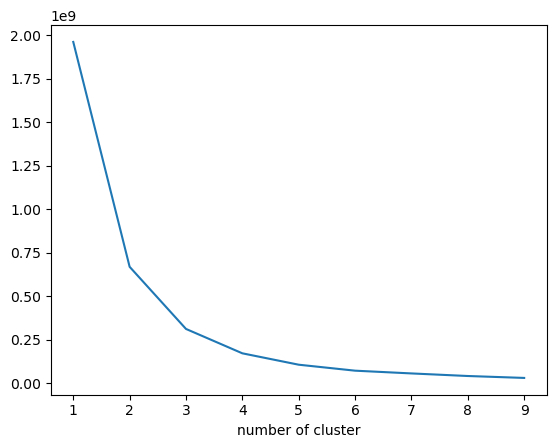

In [13]:
from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("number of cluster")
plt.show()

It looks like 3 or 4 could be optimal clusters. We will continue with 4 clusters, we can now build our recency clusters:

In [14]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

Now we need a function we will use continually for the rest of the notebook to order cluster numbers:

In [15]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [16]:
df_user

,CustomerID,Recency,RecencyCluster
0,265598,494,2
1,302645,347,2
2,285552,585,2
3,213985,365,2
4,398671,618,2
...,...,...,...
11882,896870,1501,0
11883,820595,1723,0
11884,885896,1573,0
11885,824789,1212,0


In [17]:
print(df_user['RecencyCluster'].value_counts())

2    5454
1    2891
3    2363
0    1179
Name: RecencyCluster, dtype: int64


In [18]:
recency_description = df_user.groupby('RecencyCluster')['Recency'].describe()
recency_description

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1179.0,1525.090755,196.076345,1204.0,1351.0,1517.0,1683.0,1877.0
1,2891.0,882.023175,140.412237,705.0,773.0,840.0,976.5,1201.0
2,5454.0,473.857536,91.927648,339.0,399.0,451.0,547.0,668.0
3,2363.0,155.682184,98.726434,0.0,58.0,166.0,249.0,303.0


**Recency Cluster Analysis**

Cluster 0 - Count: 1,179, mean recency: 1,525 days, std: ~196 days
This cluster has the highest mean recency, indicating that these customers have not purchased in a long time. The relatively small standard deviation suggests that most customers in this group have a similar recency level, all being well over 1,200 days.

Cluster 1 - Count: 2,891, mean recency: 882 days, std: ~140 days
Customers in this cluster have a moderate recency compared to Cluster 0. The range indicates some variability in how recently these customers have purchased, but they are still considered less active than more recent buyers.

Cluster 2- Count: 5,454, mean recency: 474 days, std: ~92 days
This cluster consists of more active customers with a mean recency of 474 days. The lower standard deviation suggests that the majority of these customers are relatively close in their purchasing recency.

Cluster 3- Count: 2,363, mean recency: 156 days, std: ~99 days
This cluster has the most recently active customers, with some having made purchases very recently (even within the same day). The low mean recency indicates strong engagement, and the standard deviation suggests that the majority of these customers are also closely grouped in terms of recency.

Cluster 3 covers most recent customers whereas cluster 0 has the most inactive ones.

# Frequency Clusters

To create frequency clusters, we need to find total number orders for each customer. First calculate this and see how frequency look like in our customer database:

In [19]:
#get order counts for each user and create a dataframe with it
df_frequency = df_data.groupby('customer_key')['order_date'].count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='CustomerID')
df_user

,CustomerID,Recency,RecencyCluster,Frequency
0,265598,494,2,8
1,302645,347,2,5
2,285552,585,2,4
3,213985,365,2,6
4,398671,618,2,6
...,...,...,...,...
11882,896870,1501,0,2
11883,820595,1723,0,1
11884,885896,1573,0,1
11885,824789,1212,0,1


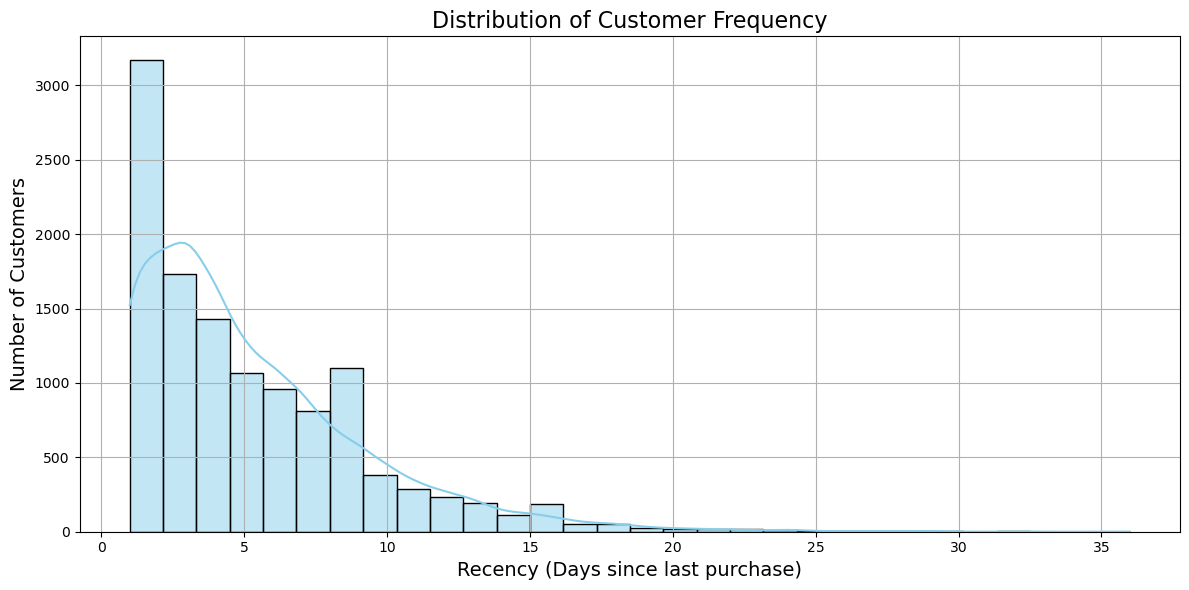

In [20]:
plt.figure(figsize=(12, 6))
sns.histplot(df_user['Frequency'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Customer Frequency', fontsize=16)
plt.xlabel('Recency (Days since last purchase)', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)


plt.grid()
plt.tight_layout()
plt.show()

Apply the same process for frequency clusters and assign to each customer:

In [21]:
#build 4 clusters for Frequency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

In [22]:
#Order the frequency cluster

df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,False)

In [23]:
frequency_description = df_user.groupby('FrequencyCluster')['Frequency'].describe()
frequency_description

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,520.0,17.017308,3.392399,14.0,15.0,16.0,18.0,36.0
1,2194.0,9.833637,1.622386,8.0,8.0,9.0,11.0,13.0
2,4268.0,5.269681,1.117494,4.0,4.0,5.0,6.0,7.0
3,4905.0,2.032416,0.820795,1.0,1.0,2.0,3.0,3.0


Clusters 0 and 1 represent our most frequent buyers, while Clusters 2 and 3 show declining levels of purchasing activity.

Of course later in the project we will discuss targeting strategies for these customer segments. As an example:

Targeting Strategy:
- Consider loyalty programs or incentives for Clusters 0 and 1 to maintain and boost their engagement.

- For Clusters 2 and 3, targeted marketing strategies could be implemented to encourage more frequent purchases. This might involve promotions, personalized offers, or outreach to understand why these customers are less active.

# Revenue Clusters

Now we'll check how our customer database looks like when we cluster based on revenue, and we'll follow the same process as before to acheive this:

In [24]:
df_data = df_data.rename(columns={'sales': 'revenue'})

In [25]:
df_revenue = df_data.groupby('customer_key')['revenue'].sum().reset_index()
df_revenue.columns = ['CustomerID','revenue']

#merge with the main dataframe
df_user = pd.merge(df_user, df_revenue, on='CustomerID')

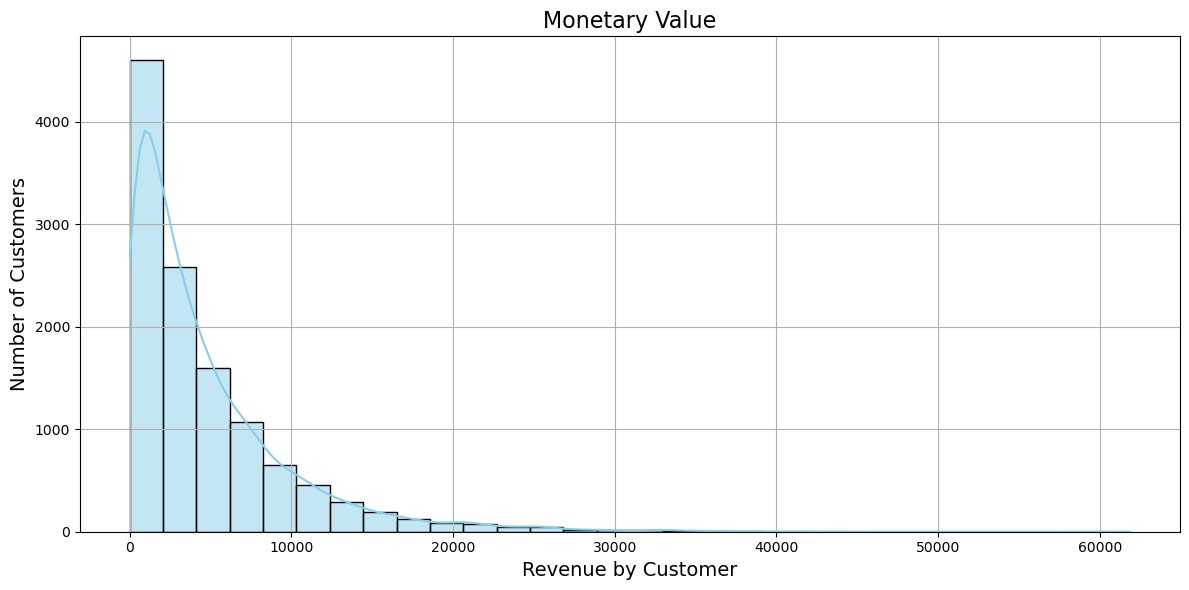

In [26]:
plt.figure(figsize=(12, 6))
sns.histplot(df_user['revenue'], bins=30, kde=True, color='skyblue')

plt.title('Monetary Value', fontsize=16)
plt.xlabel('Revenue by Customer', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)


plt.grid()
plt.tight_layout()
plt.show()

In [27]:
#build 4 clusters for revenue and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['revenue']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['revenue']])

In [28]:
#Order the revenue cluster

df_user = order_cluster('RevenueCluster', 'revenue',df_user,False)

In [29]:
revenue_description = df_user.groupby('RevenueCluster')['revenue'].describe()
revenue_description

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,359.0,24002.410585,5414.426424,18173.74,20298.465,22338.170,25851.2200,61871.70
1,1379.0,12303.296367,2392.773954,9106.96,10300.640,11760.540,13983.3000,18142.99
2,3397.0,5894.999561,1510.757873,3709.81,4557.820,5652.970,7076.0900,9102.06
3,6752.0,1502.822125,1062.552089,1.99,557.800,1342.245,2370.8825,3704.95


Customers in cluster 0 are high spenders, with a mean revenue significantly above the other clusters. The large standard deviation indicates considerable variability in spending within this group, suggesting that while some customers spend a lot, others spend somewhat less, but they all fall into the high revenue category.

Cluster 0 represents our most valuable customers, and understanding their needs and preferences can help in developing targeted marketing strategies to retain and grow this segment.

Cluster 1 has a good number of moderate spenders who could be encouraged to move up to the high-spending category with appropriate marketing strategies.

Clusters 2 and 3 show a need for strategies to increase engagement and spending. These customers may benefit from promotions, loyalty programs, or tailored marketing to encourage higher spending.

# Overall Score

Let's remind ourselves what our cluster groups look like:

In [30]:
df_user.head(2)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster
0,265598,494,2,8,1,1461.43,3
1,216550,372,2,9,1,3357.04,3


In [31]:
recency_description

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1179.0,1525.090755,196.076345,1204.0,1351.0,1517.0,1683.0,1877.0
1,2891.0,882.023175,140.412237,705.0,773.0,840.0,976.5,1201.0
2,5454.0,473.857536,91.927648,339.0,399.0,451.0,547.0,668.0
3,2363.0,155.682184,98.726434,0.0,58.0,166.0,249.0,303.0


In [32]:
frequency_description

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,520.0,17.017308,3.392399,14.0,15.0,16.0,18.0,36.0
1,2194.0,9.833637,1.622386,8.0,8.0,9.0,11.0,13.0
2,4268.0,5.269681,1.117494,4.0,4.0,5.0,6.0,7.0
3,4905.0,2.032416,0.820795,1.0,1.0,2.0,3.0,3.0


In [33]:
revenue_description

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,359.0,24002.410585,5414.426424,18173.74,20298.465,22338.170,25851.2200,61871.70
1,1379.0,12303.296367,2392.773954,9106.96,10300.640,11760.540,13983.3000,18142.99
2,3397.0,5894.999561,1510.757873,3709.81,4557.820,5652.970,7076.0900,9102.06
3,6752.0,1502.822125,1062.552089,1.99,557.800,1342.245,2370.8825,3704.95


In [34]:
#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','revenue'].mean()

/var/folders/bc/wjwf97gd507gs3nzt5hg0ys40000gn/T/ipykernel_55128/1608675509.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_user.groupby('OverallScore')['Recency','Frequency','revenue'].mean()


,Recency,Frequency,revenue
OverallScore,,,
1,966.250000,13.250000,24424.212500
2,654.647059,15.420168,22931.520420
3,625.594907,12.884259,16325.527662
4,653.753739,10.029910,11100.020937
5,653.915995,7.689873,7323.225046
6,802.646015,4.896972,3973.410292
7,619.777183,3.654065,2306.523941
8,413.218182,2.686364,1421.239373
9,167.230624,2.086957,1093.919244


The scoring appears counterintuitive: in RecencyCluster, unfavorable customers (larger means for recency) are grouped in cluster 0. 

However, in both FrequncyCluster and RevenueCluster, the more favorable customers are grouped in cluster 0. 

If we want to attribute a logical scoring system for OverallScore, we can remap the RecencyCluster so that we reverse the order and then they'll add up more logically. 

In [35]:
# Create a mapping for RevenueCluster scores
recency_score_mapping = {0: 3, 1: 2, 2: 1, 3: 0}

In [36]:
# Map the scores to a new column
df_user['RecencyCluster'] = df_user['RecencyCluster'].map(recency_score_mapping)

In [37]:
recency_description = df_user.groupby('RecencyCluster')['Recency'].describe()
recency_description

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2363.0,155.682184,98.726434,0.0,58.0,166.0,249.0,303.0
1,5454.0,473.857536,91.927648,339.0,399.0,451.0,547.0,668.0
2,2891.0,882.023175,140.412237,705.0,773.0,840.0,976.5,1201.0
3,1179.0,1525.090755,196.076345,1204.0,1351.0,1517.0,1683.0,1877.0


Now the more favorable customers (low recency mean values) are in cluster 0 just like the more favorable values are in the frequency and revenue groups for their respective metrics. Now we'll rescore the overall score:

In [38]:
#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','revenue'].mean()

/var/folders/bc/wjwf97gd507gs3nzt5hg0ys40000gn/T/ipykernel_55128/1608675509.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_user.groupby('OverallScore')['Recency','Frequency','revenue'].mean()


,Recency,Frequency,revenue
OverallScore,,,
0,127.859375,19.906250,24446.128125
1,230.925110,16.414097,18925.111894
2,283.259714,12.496933,14099.979796
3,331.798467,10.031763,10371.998007
4,395.095129,8.043379,7270.007603
5,447.104155,5.982356,5165.581360
6,510.709267,4.240228,3151.455213
7,645.208448,2.805369,1877.720328
8,983.766150,2.197028,1397.207649


This is more intuitive, although a lower overall score indivates higher value in this list and vice versa. This isn't a problem as we're going to now categorize these scores in three different groups to keep things simple. 

- High Value: Overall scores 0 to 3
- Mid Value: Overall scores 4 to 6
- Low Value: Overall scores 7 to 9

We'll apply this naming to our dataframe:

In [39]:
# Initialize all segments to 'Low-Value'
df_user['Segment'] = 'Low-Value'

# Assign 'Mid-Value' for scores between 4 and 6
df_user.loc[df_user['OverallScore'].between(4, 6), 'Segment'] = 'Mid-Value'

# Assign 'High-Value' for scores between 0 and 3
df_user.loc[df_user['OverallScore'] <= 3, 'Segment'] = 'High-Value'

In [40]:
df_user.head(2)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,OverallScore,Segment
0,265598,494,1,8,1,1461.43,3,5,Mid-Value
1,216550,372,1,9,1,3357.04,3,5,Mid-Value


# Visualize Clusters

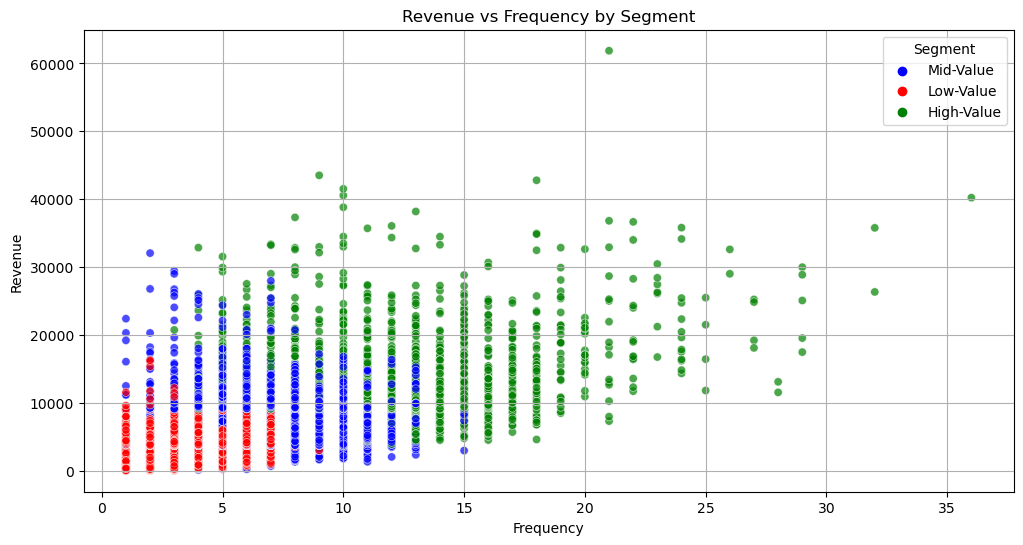

In [41]:
#Revenue vs Frequncy 

color_palette = {
    'High-Value': 'green',
    'Mid-Value': 'blue',
    'Low-Value': 'red'
}

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Frequency',
    y='revenue',
    hue='Segment',
    data=df_user,
    palette=color_palette, 
    alpha=0.7
)

# Add titles and labels
plt.title('Revenue vs Frequency by Segment')
plt.xlabel('Frequency')
plt.ylabel('Revenue')
plt.legend(title='Segment')
plt.grid()

# Show the plot
plt.show()

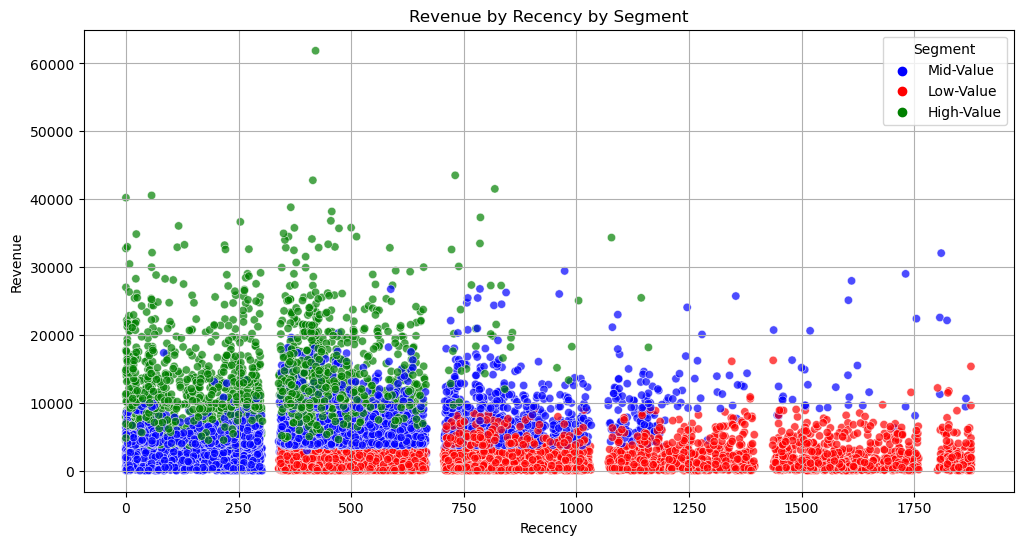

In [42]:
#Revenue vs Recency

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Recency',
    y='revenue',
    hue='Segment',
    data=df_user,
    palette=color_palette, 
    alpha=0.7
)

# Add titles and labels
plt.title('Revenue by Recency by Segment')
plt.xlabel('Recency')
plt.ylabel('Revenue')
plt.legend(title='Segment')
plt.grid()

# Show the plot
plt.show()

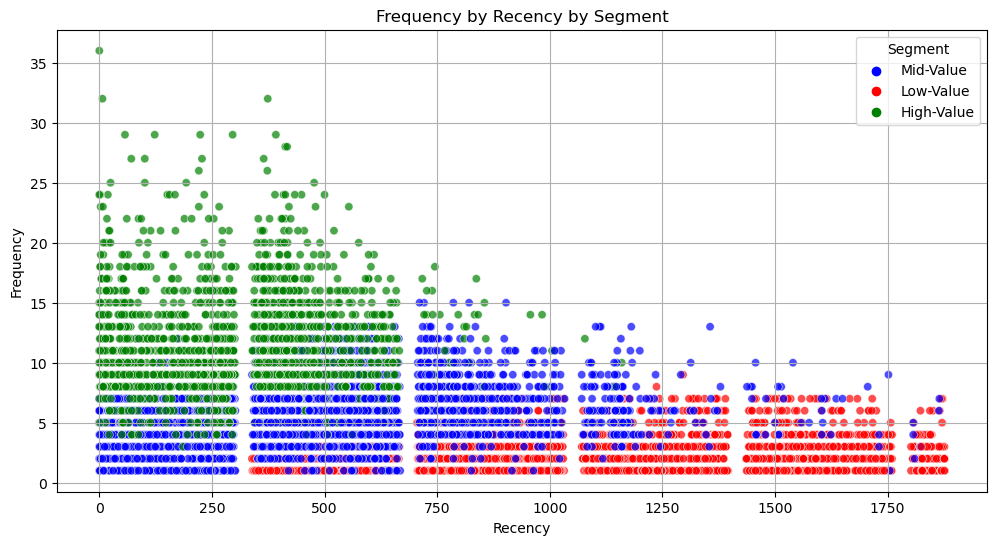

In [43]:
# Frequency by Recency

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Recency',
    y='Frequency',
    hue='Segment',
    data=df_user,
    palette=color_palette, 
    alpha=0.7
)

# Add titles and labels
plt.title('Frequency by Recency by Segment')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Segment')
plt.grid()

# Show the plot
plt.show()

We can see how the segments are clearly differentiated from each other in terms of RFM.

This is an exciting part of the analysis. 

In the first plot, we observe a clear relationship where higher frequency of purchases correlates with greater revenue. Additionally, groups exhibiting more recent purchasing behavior tend to generate higher revenue. This trend is understandable, given that the data covers a five-year period; shorter intervals between purchases provide more opportunities for increased frequency.

The main strategies going forward are quite clear:

- High Value: Improve Retention
- Mid Value: Improve retention + increase frequency
- Low values: Increase Frequency

# Customer Lifetime Value

There are various methods to calculate CLV. The most common ones include:

- Historical CLV: Based on past purchase behavior.
- Predictive CLV: Uses predictive analytics to forecast future purchases.

Infomration to gather for our customer segments:
- **Average Purchase Value (APV)**: Total revenue divided by the number of purchases.
- **Purchase Frequency (PF)**: Total number of purchases 
- **Customer Lifespan (CL)**: Average duration a customer continues to purchase.

Our formula for historic, individual customer lifetime value will be:

HCLV = Total Revenue / Total Number of Purchases * Lifespan (# of years)

In [44]:
df_user.head(2)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,OverallScore,Segment
0,265598,494,1,8,1,1461.43,3,5,Mid-Value
1,216550,372,1,9,1,3357.04,3,5,Mid-Value


In [45]:
df_data.head(2)

,order_number,line_item,order_date,customer_key,store_key,product_key,quantity,currency_code,product_name,brand,...,city,gender,zip_code,birthday,birth_year,order_year,order_month,age_purchase,age_group,years_open
0,366000,1,2016-01-01,265598,10,1304,1,CAD,Contoso Lens Adapter M450 White,Contoso,...,London,Male,N5W 5K6,1971-03-23,1971,2016,1,45,36-45,0.745205
1,1749017,1,2019-10-15,265598,0,1619,1,CAD,Contoso DVD Player M130 Grey,Contoso,...,London,Male,N5W 5K6,1971-03-23,1971,2019,10,48,46-55,9.791781


To quickly remind ourselves, we still have our main dataframe which we started with df_data and the new dataset that we built in this notebook df_user that contains our clusters and segment values. We won't merge these sets just yet, but we will at a later point in order to improve our modelling efforts.

In [46]:
user_total_revenue = df_data.groupby('customer_key')['revenue'].sum()
purchase_count = df_data.groupby('customer_key')['quantity'].count()


average_purchase_value = user_total_revenue / purchase_count
average_purchase_value

customer_key
301         592.000000
325         578.767000
554         237.927500
1042        374.970000
1314        507.972000
              ...     
2099383     623.166667
2099600     423.613333
2099758     132.477500
2099862     167.166667
2099937    1962.565000
Length: 11887, dtype: float64

In [47]:
average_purchase_value.describe()

count    11887.000000
mean       880.894046
std        962.727960
min          1.990000
25%        374.646250
50%        660.048571
75%       1070.015357
max      22399.930000
dtype: float64

**Steps to Calculate Customer Lifespan:**

Identify following dates:
- Minimum purchase date: the date of first purchase
- Maxium purchase date: the date of the most recent purchase 

lifespan = Max purchase date - Min purcahse date 

**Considerations**

- Active vs. Inactive Periods: This method assumes the customer has been active continuously from their first purchase to their last. If there are long gaps between purchases, you may want to consider defining a customer as "active" for a specific time period (e.g., 12 months) after their last purchase.

- Churn Rate: If you have data on when customers stop purchasing, incorporating churn rates can give you a more accurate picture of lifespan.

- Cohort Analysis: You might also consider segmenting customers based on their purchase behavior over time, which can help refine your understanding of lifespan.

Given that we calculated previous the average recency is 614 days, with a median of 508 days and for the fact that the products our retailer sells have a longer lifetime and less purchase frequency, we will use the simple formula to calculate the lifespan of a customer.

In [48]:
min_purchase_date = df_data.groupby('customer_key')['order_date'].min()
max_purchase_date = df_data.groupby('customer_key')['order_date'].max()

In [49]:
customer_lifespan = (max_purchase_date - min_purchase_date).dt.days / 365 #convert to years
customer_lifespan

customer_key
301        0.000000
325        1.975342
554        1.917808
1042       0.000000
1314       0.000000
             ...   
2099383    1.865753
2099600    0.000000
2099758    0.778082
2099862    0.000000
2099937    1.652055
Name: order_date, Length: 11887, dtype: float64

In [50]:
customer_lifespan.describe()

count    11887.000000
mean         1.166449
std          1.310936
min          0.000000
25%          0.000000
50%          0.723288
75%          2.101370
max          5.090411
Name: order_date, dtype: float64

In [51]:
customer_metrics = pd.DataFrame({
    'CustomerID': user_total_revenue.index,
    'total_revenue': user_total_revenue.values,
    'total_purchases': purchase_count.values,
    'customer_lifespan': customer_lifespan.values
})

We have to now make one small adjustment. Some customers will show 0 under the customer_lifespan becuase they've only purchased once; which means their max day and min day are the same, and if we subtract those days from each other we will get 0. 

It wouldn't make sense to keep these customers lifespan at 0 given that they have in fact purchased and in order to complete our lifetime_value calculation, we would have to multiply by 0 (the lifespan) and that would make the entire lifetime value equal to 0. This would of course not be the correc tthing to do, because some customers could have one really expensive purchase which is great for the business, but we would label them as low-end customers. 

In order to deal with this, we will replace any zero values with 1 to avoid issues in calculations. 

In [52]:
#Replace 0 with 1 
customer_metrics['customer_lifespan'] = customer_metrics['customer_lifespan'].replace(0, 1)

In [53]:
#Calculate Lifetime Value
customer_metrics['lifetime_value'] = (
    customer_metrics['total_revenue'] / customer_metrics['total_purchases'] *
    customer_metrics['customer_lifespan']
)

In [54]:
random_sample = customer_metrics.sample(n=5)
random_sample

,CustomerID,total_revenue,total_purchases,customer_lifespan,lifetime_value
169,45436,1026.46,4,2.400000,615.876000
7693,1435081,1599.68,2,1.000000,799.840000
7738,1441731,1133.35,4,1.323288,374.937021
3308,643248,491.76,2,1.000000,245.880000
8533,1568944,15834.33,10,3.095890,4902.135041


In [55]:
#Merge back to original dataframe 'df_data'

df_user = df_user.merge(customer_metrics[['CustomerID', 'customer_lifespan', 'lifetime_value']],
                         on='CustomerID', how='left')

In [56]:
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,OverallScore,Segment,customer_lifespan,lifetime_value
0,265598,494,1,8,1,1461.43,3,5,Mid-Value,3.789041,692.177291
1,216550,372,1,9,1,3357.04,3,5,Mid-Value,4.043836,1508.368658
2,322558,641,1,10,1,3381.26,3,5,Mid-Value,1.556164,526.179638
3,392676,416,1,9,1,2507.80,3,5,Mid-Value,0.994521,277.117626
4,305226,497,1,8,1,3120.39,3,5,Mid-Value,0.909589,354.784068


In [57]:
df_user['lifetime_value'].describe()

count    11887.000000
mean      1384.614943
std       1760.304665
min          0.246320
25%        359.714845
50%        851.096942
75%       1768.054247
max      30549.141123
Name: lifetime_value, dtype: float64

In [58]:
#After merging, always good to check for Nan values

df_user.isna().sum()

CustomerID           0
Recency              0
RecencyCluster       0
Frequency            0
FrequencyCluster     0
revenue              0
RevenueCluster       0
OverallScore         0
Segment              0
customer_lifespan    0
lifetime_value       0
dtype: int64

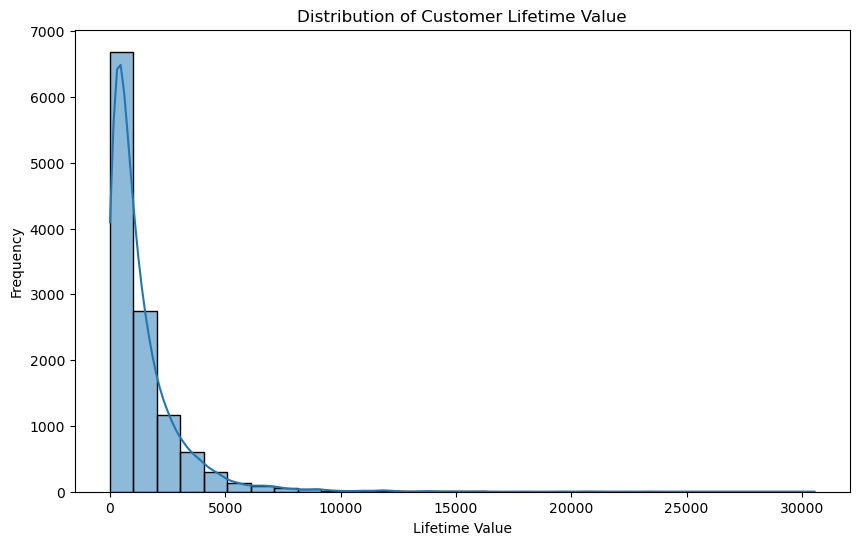

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(df_user['lifetime_value'], bins=30, kde=True)  # KDE adds a smooth line
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('Lifetime Value')
plt.ylabel('Frequency')
plt.show()

In [60]:
#Create clusters for lifetime value 

kmeans = KMeans(n_clusters=3)
kmeans.fit(df_user[['lifetime_value']])
df_user['LifetimeValueCluster'] = kmeans.predict(df_user[['lifetime_value']])

In [61]:
df_user = order_cluster('LifetimeValueCluster', 'lifetime_value',df_user,False)

In [62]:
lifetime_description = df_user.groupby('LifetimeValueCluster')['lifetime_value'].describe()
lifetime_description

,count,mean,std,min,25%,50%,75%,max
LifetimeValueCluster,,,,,,,,
0,245.0,9559.249014,4005.541168,6362.282500,6981.561597,8030.477930,10734.658455,30549.141123
1,2434.0,3124.908605,1020.016746,1914.376747,2298.433290,2842.200006,3727.683902,6328.443288
2,9208.0,707.088866,512.053375,0.246320,273.870168,611.349804,1067.616015,1913.235982


In [63]:
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,OverallScore,Segment,customer_lifespan,lifetime_value,LifetimeValueCluster
0,265598,494,1,8,1,1461.43,3,5,Mid-Value,3.789041,692.177291,2
1,216550,372,1,9,1,3357.04,3,5,Mid-Value,4.043836,1508.368658,2
2,322558,641,1,10,1,3381.26,3,5,Mid-Value,1.556164,526.179638,2
3,392676,416,1,9,1,2507.80,3,5,Mid-Value,0.994521,277.117626,2
4,305226,497,1,8,1,3120.39,3,5,Mid-Value,0.909589,354.784068,2


Amazing, now we have also added a **historic customer lifetime value metric** to our customer data table along with a RFM score. 

Once we continue some feature engineering and pre-processing in a later notebook, we will circle back to this data in order to predict *Future Lifetime Value*. 

This will also include predicting customer churn, discovering feature importance and what drives our business and so on. 


In [64]:
df_data.head()

,order_number,line_item,order_date,customer_key,store_key,product_key,quantity,currency_code,product_name,brand,...,city,gender,zip_code,birthday,birth_year,order_year,order_month,age_purchase,age_group,years_open
0,366000,1,2016-01-01,265598,10,1304,1,CAD,Contoso Lens Adapter M450 White,Contoso,...,London,Male,N5W 5K6,1971-03-23,1971,2016,1,45,36-45,0.745205
1,1749017,1,2019-10-15,265598,0,1619,1,CAD,Contoso DVD Player M130 Grey,Contoso,...,London,Male,N5W 5K6,1971-03-23,1971,2019,10,48,46-55,9.791781
2,1749017,3,2019-10-15,265598,0,52,1,CAD,WWI 2GB Pulse Smart pen M100 Silver,Wide World Importers,...,London,Male,N5W 5K6,1971-03-23,1971,2019,10,48,46-55,9.791781
3,1749017,2,2019-10-15,265598,0,1764,2,CAD,MGS Age of Empires II: The Age of Kings E126,Tailspin Toys,...,London,Male,N5W 5K6,1971-03-23,1971,2019,10,48,46-55,9.791781
4,891000,2,2017-06-09,265598,9,174,1,CAD,SV 22xDVD M600 Black,Southridge Video,...,London,Male,N5W 5K6,1971-03-23,1971,2017,6,46,46-55,12.273973


In [65]:
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,revenue,RevenueCluster,OverallScore,Segment,customer_lifespan,lifetime_value,LifetimeValueCluster
0,265598,494,1,8,1,1461.43,3,5,Mid-Value,3.789041,692.177291,2
1,216550,372,1,9,1,3357.04,3,5,Mid-Value,4.043836,1508.368658,2
2,322558,641,1,10,1,3381.26,3,5,Mid-Value,1.556164,526.179638,2
3,392676,416,1,9,1,2507.80,3,5,Mid-Value,0.994521,277.117626,2
4,305226,497,1,8,1,3120.39,3,5,Mid-Value,0.909589,354.784068,2


In [66]:
df_data.to_csv('~/Desktop/retailer_data2.csv', index=False)

In [67]:
df_user.to_csv('~/Desktop/retailer_user2.csv', index=False)